<center><h1>Thai_Khang_HW6</h1></center>

Name: Khang Thai
<br>
Github Username: kunfupen
<br>
USC ID: 5721113147

## 1. Tree-Based Methods

Import packages

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE

### (a) Download the APS Failure data

In [23]:
train_data = pd.read_csv('aps_failure_training_set.csv', skiprows=20, na_values='na')
test_data = pd.read_csv('aps_failure_test_set.csv', skiprows=20, na_values='na')

### (b) Data Preparation

#### (i) Research what types of techniques are usually used

Deletion methods - listwise deletion, pairwise deletion, dropping entire variables.

Imputation methods - mean/mode/median imputation, regression imputation, multiple imputation.

#### (ii) Calculate the coefficient of variation

In [24]:
x_train = train_data.drop(columns=['class'])
y_train = train_data['class']
x_test = test_data.drop(columns=['class'])
y_test = test_data['class']

train_missing = x_train.isnull().sum()
test_missing_pct = (train_missing / len(x_train)) * 100
test_missing = x_test.isnull().sum()

imputer = SimpleImputer(strategy='median')

x_train_imputed = pd.DataFrame(
    imputer.fit_transform(x_train), 
    columns=x_train.columns,
    index=x_train.index
)
x_test_imputed = pd.DataFrame(
    imputer.transform(x_test),
    columns=x_test.columns,
    index=x_test.index
)

feat_with_missing = train_missing[train_missing > 0].index[:3]
for feat in feat_with_missing:
    median_value = imputer.statistics_[x_train.columns.get_loc(feat)]

x_train_imputed.to_csv('x_train_imputed.csv', index=False)
x_test_imputed.to_csv('x_test_imputed.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

x_train_imputed = pd.read_csv('x_train_imputed.csv')
x_test_imputed = pd.read_csv('x_test_imputed.csv')

cv_res = []

for col in x_train_imputed.columns:
    mean_val = x_train_imputed[col].mean()
    std_val = x_train_imputed[col].std()

    if mean_val != 0:
        cv = std_val / abs(mean_val)
    else:
        cv = np.inf

    cv_res.append({
        'feature': col,
        'mean': mean_val,
        'std': std_val,
        'cv': cv
    })

cv_df = pd.DataFrame(cv_res)
cv_df = cv_df.sort_values(by='cv', ascending=False).reset_index(drop=True)

for inx, row in cv_df.head(10).iterrows():
    print(f"{inx + 1}. Feature: {row['feature']}, Mean: {row['mean']:.2f}, Std: {row['std']:.2f}, CV: {row['cv']:.4f}")



1. Feature: cf_000, Mean: 143107.53, Std: 35045248.64, CV: 244.8875
2. Feature: co_000, Mean: 143330.02, Std: 35045247.84, CV: 244.5074
3. Feature: ad_000, Mean: 143438.29, Std: 35045247.41, CV: 244.3228
4. Feature: cs_009, Mean: 770.51, Std: 183327.80, CV: 237.9306
5. Feature: dh_000, Mean: 4392.64, Std: 541244.06, CV: 123.2161
6. Feature: dj_000, Mean: 37.27, Std: 4379.17, CV: 117.4942
7. Feature: ag_000, Mean: 219.16, Std: 20363.64, CV: 92.9178
8. Feature: as_000, Mean: 125.41, Std: 10952.19, CV: 87.3325
9. Feature: ay_009, Mean: 1149.62, Std: 97411.56, CV: 84.7337
10. Feature: ak_000, Mean: 907.66, Std: 72998.59, CV: 80.4250


#### (iii) Plot a correlation matrix

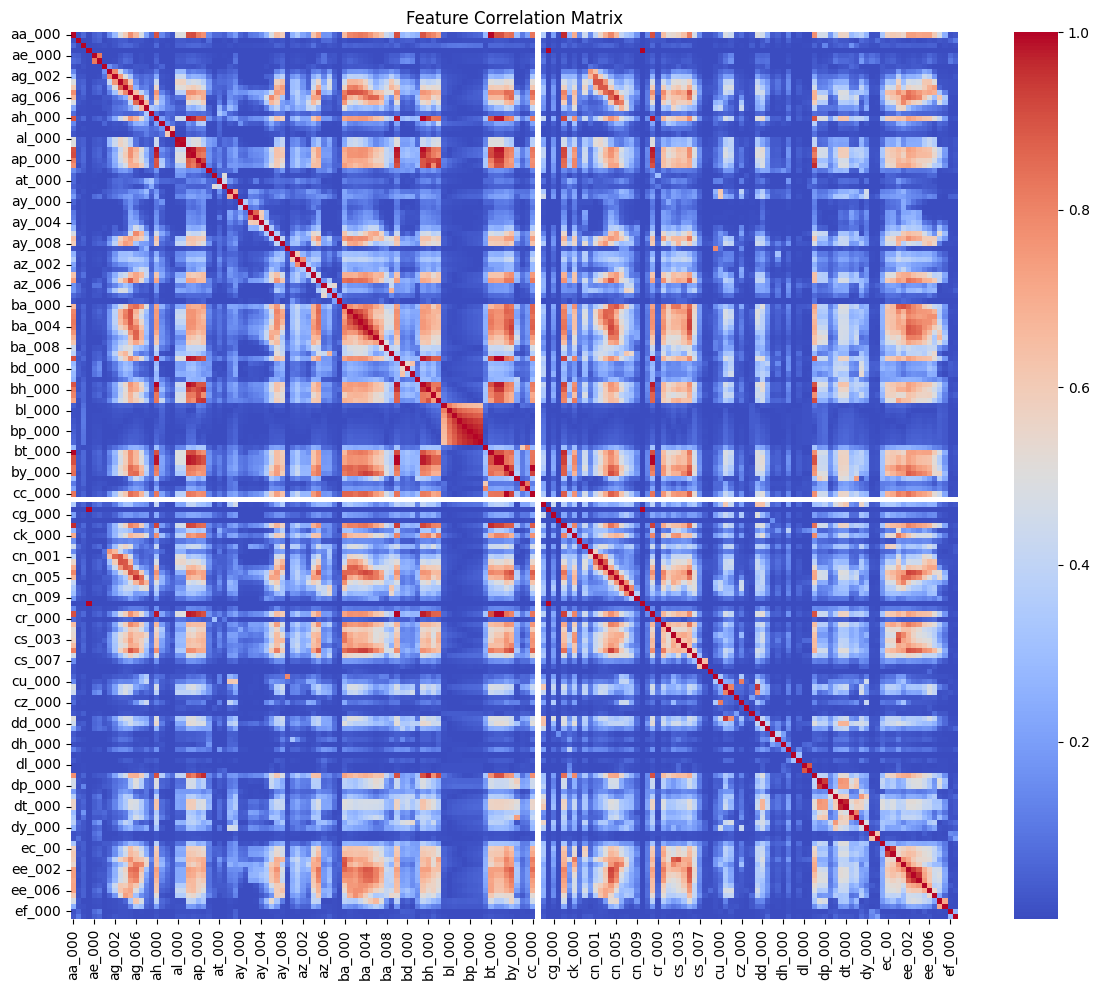

In [25]:
corr_mat = x_train_imputed.corr().abs()

plt.figure(figsize=(12, 10))

sns.heatmap(corr_mat, cmap='coolwarm', annot=False)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

#### (iv) Make scatter plots and box plots

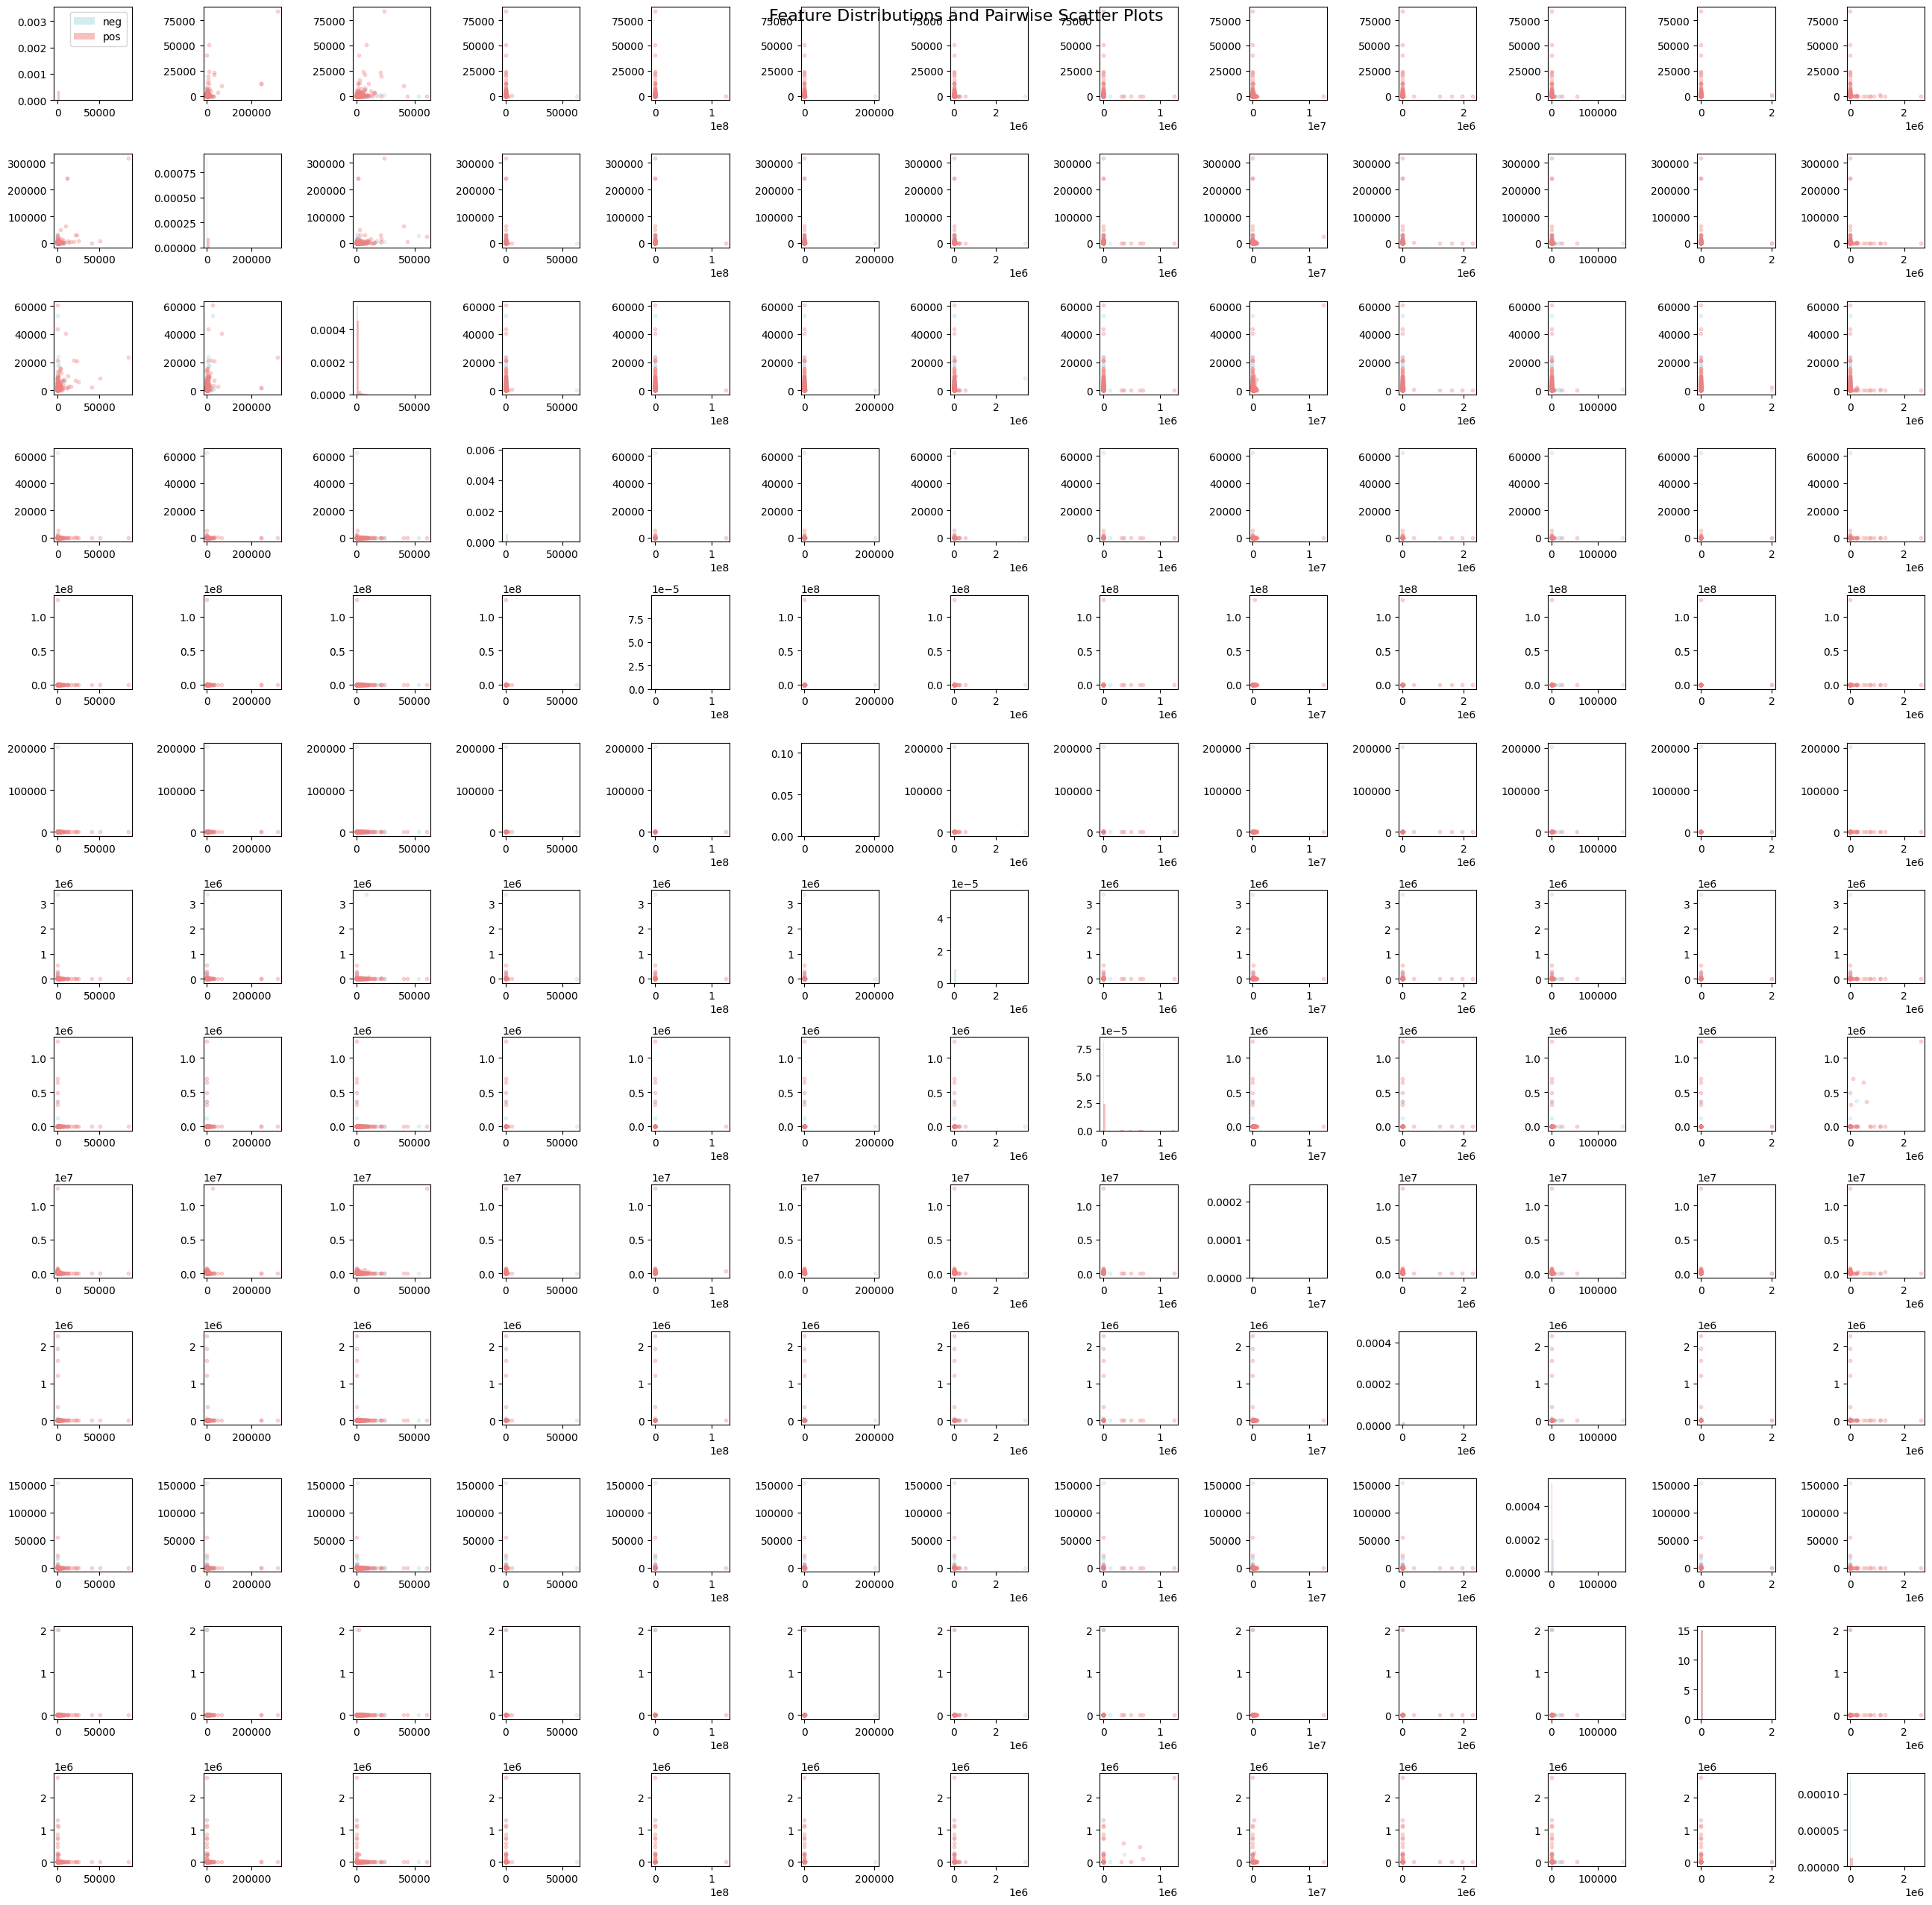

Cannot draw conclusion about significance of the different features


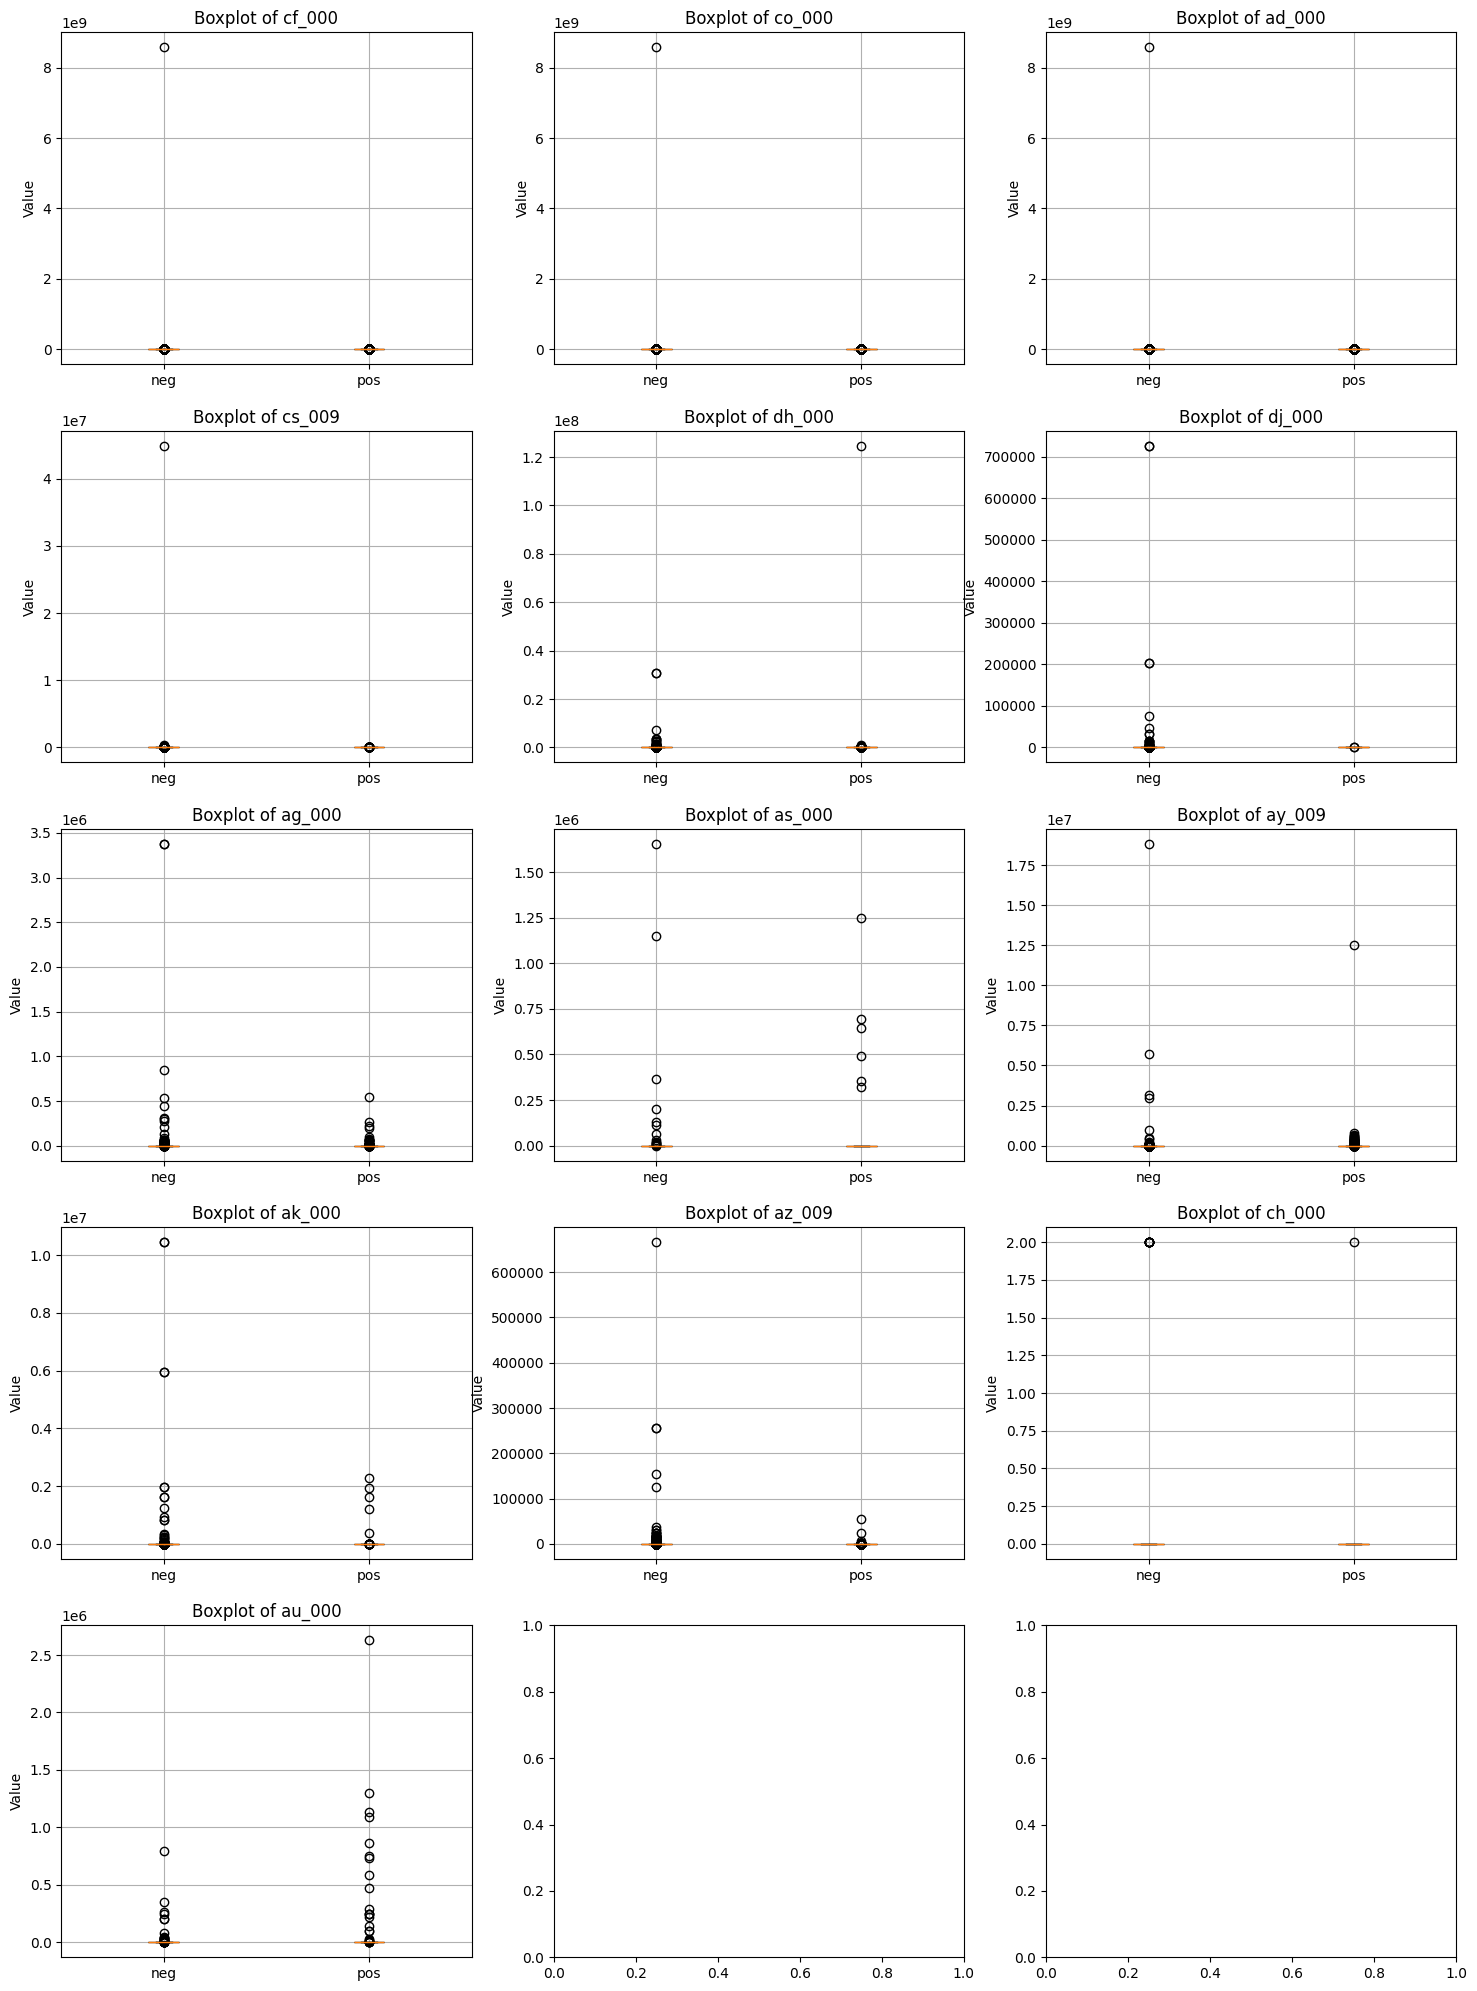

In [61]:
cv_res = []

for col in x_train_imputed.columns:
    mean_val = x_train_imputed[col].mean()
    std_val = x_train_imputed[col].std()

    if mean_val != 0:
        cv = std_val / abs(mean_val)
    else:
        cv = np.inf

    cv_res.append({
        'feature': col,
        'mean': mean_val,
        'std': std_val,
        'cv': cv
    })


cv_df = pd.DataFrame(cv_res)
cv_df = cv_df.sort_values(by='cv', ascending=False).reset_index(drop=True)

n_feat = int(np.sqrt(170))

top_feat = cv_df.head(n_feat)['feature'].tolist()
for i, feat in enumerate(top_feat, 1):
    cv_val = cv_df[cv_df['feature'] == feat]['cv'].values[0]

plt_data = x_train_imputed[top_feat].copy()
plt_data['class'] = y_train.values.flatten()

pos_sample = plt_data[plt_data['class'] == 'pos']
neg_sample = plt_data[plt_data['class'] == 'neg'].sample(n=5000, random_state=42)
plt_viz = pd.concat([neg_sample,pos_sample])

fig, axes = plt.subplots(n_feat, n_feat, figsize=(26, 26))

for i in range(n_feat):
    for j in range(n_feat):
        ax = axes[i, j]

        if i == j:
            pos_data = plt_viz[plt_viz['class'] == 'pos'][top_feat[i]]
            neg_data = plt_viz[plt_viz['class'] == 'neg'][top_feat[i]]
            ax.hist(neg_data, bins=30, alpha=0.5, label='neg', color='lightblue', density=True)
            ax.hist(pos_data, bins=30, alpha=0.5, label='pos', color='lightcoral', density=True)
            
            if i == 0:
                ax.legend()
        else:
            neg_data = plt_viz[plt_viz['class'] == 'neg']
            pos_data = plt_viz[plt_viz['class'] == 'pos']

            ax.scatter(neg_data[top_feat[j]], neg_data[top_feat[i]], alpha=0.3, label='neg', color='lightblue', s=10)
            ax.scatter(pos_data[top_feat[j]], pos_data[top_feat[i]], alpha=0.3, label='pos', color='lightcoral', s=10)

        if i != j:
            x_range = plt_viz[top_feat[j]].max() - plt_viz[top_feat[j]].min()
            y_range = plt_viz[top_feat[i]].max() - plt_viz[top_feat[i]].min()



plt.suptitle('Feature Distributions and Pairwise Scatter Plots', fontsize=16)
plt.tight_layout()
plt.show()


n_col = 3
n_row = int(np.ceil(n_feat / n_col))

fig, axes = plt.subplots(n_row, n_col, figsize=(18, 5 * n_row))
axes = axes.flatten()

for idx, feat in enumerate(top_feat):
    ax = axes[idx]
    
    pos_data = plt_data[plt_data['class'] == 'pos'][feat]
    neg_data = plt_data[plt_data['class'] == 'neg'][feat]

    bp = ax.boxplot([neg_data, pos_data], tick_labels=['neg', 'pos'], patch_artist=True)

    bp['boxes'][0].set(facecolor='lightblue')
    bp['boxes'][1].set(facecolor='lightcoral')
    ax.set_title(f'Boxplot of {feat}')
    ax.set_ylabel('Value')
    ax.grid()
    ax.tick_params()

print("Cannot draw conclusion about significance of the different features")


#### (v) Is this data set imbalanced?

In [27]:
if isinstance(y_train, pd.DataFrame):
    if 'class' in y_train.columns:
        train_counts = y_train['class'].value_counts()
    else:
        train_counts = y_train.iloc[:,0].value_counts()
else:
    train_counts = y_train.value_counts()

train_total = len(y_train)

for cls, count in train_counts.items():
    pct = (count / train_total) * 100
    print(f"Class: {cls}, Count: {count}, Percentage: {pct:.2f}%")

pos_count = train_counts['pos']
neg_count = train_counts['neg']
imbalance_ratio = neg_count / pos_count

print(f"Imbalance Ratio (neg/pos): {imbalance_ratio:.2f}")
print("Dataset is imbalanced")

Class: neg, Count: 59000, Percentage: 98.33%
Class: pos, Count: 1000, Percentage: 1.67%
Imbalance Ratio (neg/pos): 59.00
Dataset is imbalanced


### (c) Train a random forest

Training Metrics:
Accuracy: 1.0000
Misclassification Rate: 0.0000
Precision: 1.0000
Recall: 0.9990
F1 Score: 0.9995
AUC: 1.0000

Testing Metrics:
Accuracy: 0.9924
Misclassification Rate: 0.0076
Precision: 0.9472
Recall: 0.7173
F1 Score: 0.8164
AUC: 0.9927

OOB Score: 0.9938
OOB Error Rate: 0.0062
Test error: 0.0076
Difference: 0.0014


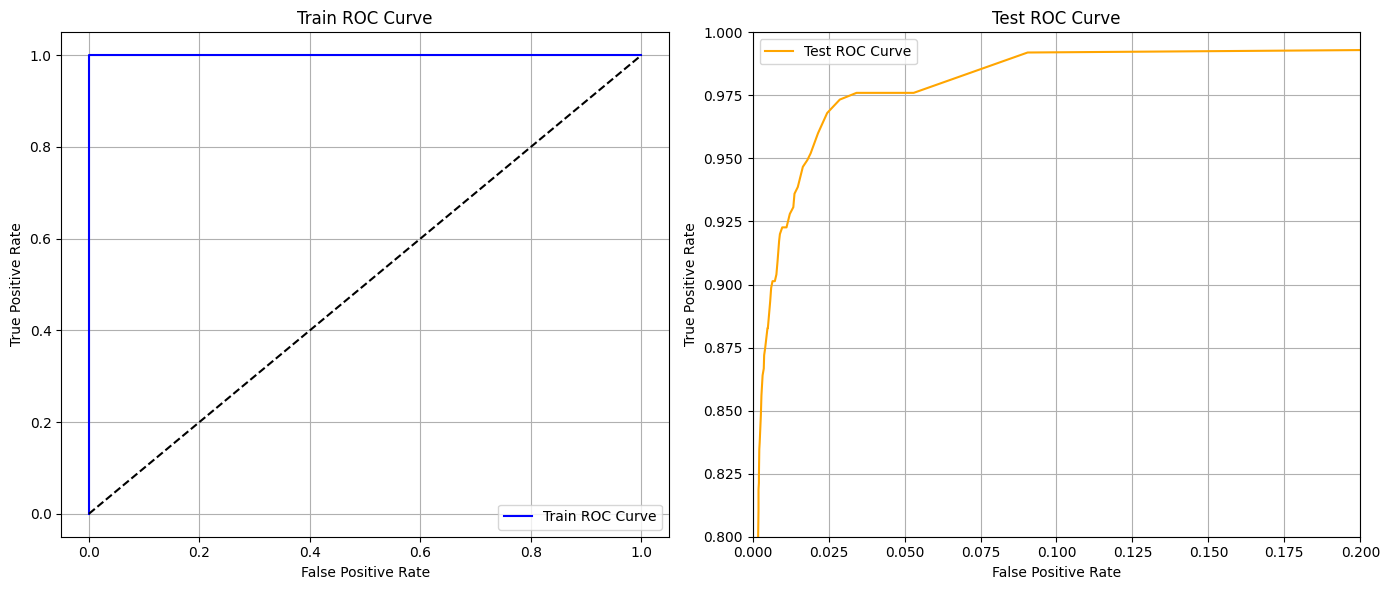

In [71]:
y_train_binary = (y_train == 'pos').astype(int)
y_test_binary = (y_test == 'pos').astype(int)

rf_model = RandomForestClassifier(
    n_estimators=100, 
    class_weight=None, 
    oob_score=True,
    random_state=42, 
    n_jobs=-1
)

rf_model.fit(x_train_imputed, y_train_binary)

y_train_pred = rf_model.predict(x_train_imputed)
y_test_pred = rf_model.predict(x_test_imputed)
y_train_proba = rf_model.predict_proba(x_train_imputed)[:, 1]
y_test_proba = rf_model.predict_proba(x_test_imputed)[:, 1]

cm_train = confusion_matrix(y_train_binary, y_train_pred)
cm_test = confusion_matrix(y_test_binary, y_test_pred)

tn_train, fp_train, fn_train, tp_train = cm_train.ravel()
tn_test, fp_test, fn_test, tp_test = cm_test.ravel()

accuracy_train = accuracy_score(y_train_binary, y_train_pred)
misclass_train = 1 - accuracy_train
precision_train = tp_train / (tp_train + fp_train) if (tp_train + fp_train) > 0 else 0
recall_train = tp_train / (tp_train + fn_train) if (tp_train + fn_train) > 0 else 0
f1_train = 2 * (precision_train * recall_train) / (precision_train + recall_train) if (precision_train + recall_train) > 0 else 0

accuracy_test = accuracy_score(y_test_binary, y_test_pred)
misclass_test = 1 - accuracy_test
precision_test = tp_test / (tp_test + fp_test) if (tp_test + fp_test) > 0 else 0
recall_test = tp_test / (tp_test + fn_test) if (tp_test + fn_test) > 0 else 0
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test) if (precision_test + recall_test) > 0 else 0

auc_train = roc_auc_score(y_train_binary, y_train_proba)
auc_test = roc_auc_score(y_test_binary, y_test_proba)

print("Training Metrics:")
print(f"Accuracy: {accuracy_train:.4f}")
print(f"Misclassification Rate: {misclass_train:.4f}") 
print(f"Precision: {precision_train:.4f}")
print(f"Recall: {recall_train:.4f}") 
print(f"F1 Score: {f1_train:.4f}")
print(f"AUC: {auc_train:.4f}")

print("\nTesting Metrics:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Misclassification Rate: {misclass_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1 Score: {f1_test:.4f}")
print(f"AUC: {auc_test:.4f}")

oob_score = rf_model.oob_score_
oob_error = 1 - oob_score
print(f"\nOOB Score: {oob_score:.4f}")
print(f"OOB Error Rate: {oob_error:.4f}")
print(f"Test error: {misclass_test:.4f}")
print(f"Difference: {abs(oob_error - misclass_test):.4f}")

fpr_train, tpr_train, _ = roc_curve(y_train_binary, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test_binary, y_test_proba)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].plot(fpr_train, tpr_train, label='Train ROC Curve', color='blue')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Train ROC Curve')
axes[0].legend()
axes[0].grid()

axes[1].plot(fpr_test, tpr_test, label='Test ROC Curve', color='orange')
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_xlim(0, 0.2)
axes[1].set_ylim(0.8, 1)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Test ROC Curve')
axes[1].legend()
axes[1].grid()


plt.tight_layout()
plt.show()


### (d) Research class imbalance in random forest

Balanced Training Metrics:
Accuracy: 1.0000
Misclassification Rate: 0.0000
Precision: 1.0000
Recall: 0.9990
F1 Score: 0.9995
AUC: 1.0000

Balanced Testing Metrics:
Accuracy: 0.9891
Misclassification Rate: 0.0109
Precision: 0.9389
Recall: 0.5733
F1 Score: 0.7119
AUC: 0.9919

Balanced OOB Score: 0.9918
Balanced OOB Error Rate: 0.0082
Balanced Test error: 0.0109
Difference: 0.0027


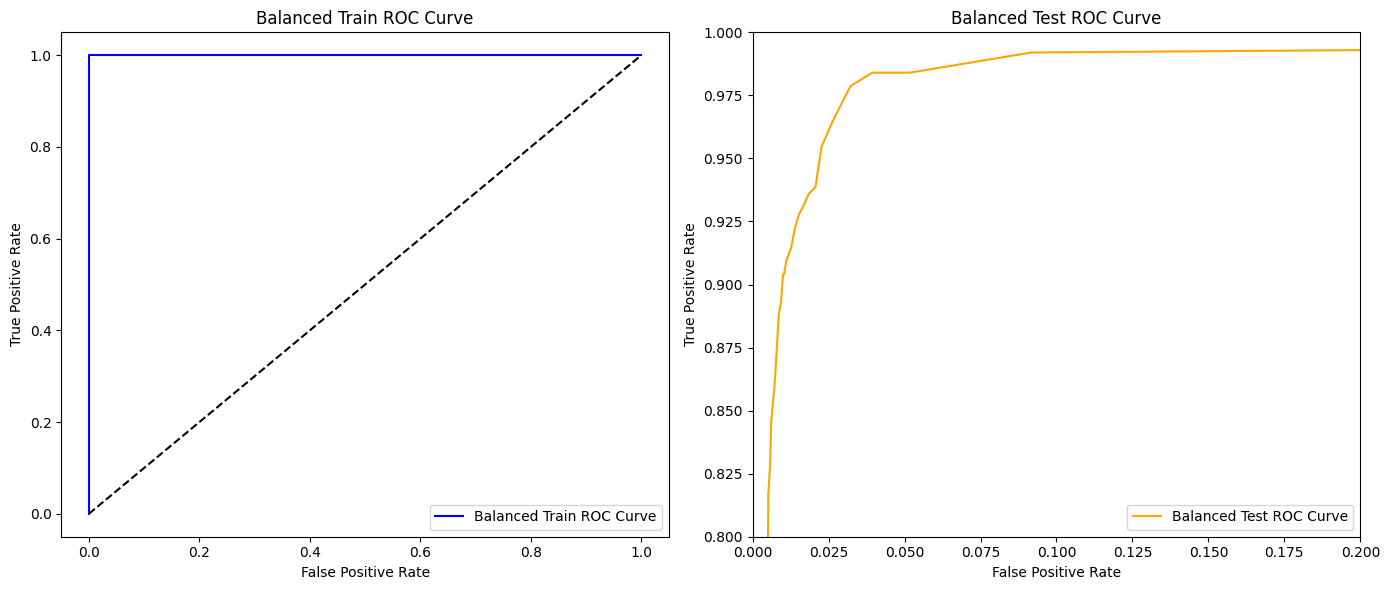

Recall did not improve with class weighting compared to 1c.


In [73]:
classes = np.array([0, 1])
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train_binary
)
class_weight_dict = dict(zip(classes, class_weights))

rf_balanced_model = RandomForestClassifier(
    n_estimators=100, 
    class_weight=class_weight_dict, 
    oob_score=True,
    random_state=42, 
    n_jobs=-1
)

rf_balanced_model.fit(x_train_imputed, y_train_binary)

y_train_bal_pred = rf_balanced_model.predict(x_train_imputed)
y_test_bal_pred = rf_balanced_model.predict(x_test_imputed)
y_train_bal_proba = rf_balanced_model.predict_proba(x_train_imputed)[:, 1]
y_test_bal_proba = rf_balanced_model.predict_proba(x_test_imputed)[:, 1]

cm_train_bal = confusion_matrix(y_train_binary, y_train_bal_pred)
cm_test_bal = confusion_matrix(y_test_binary, y_test_bal_pred)

tn_train_bal, fp_train_bal, fn_train_bal, tp_train_bal = cm_train_bal.ravel()
tn_test_bal, fp_test_bal, fn_test_bal, tp_test_bal = cm_test_bal.ravel()

accuracy_train_bal = accuracy_score(y_train_binary, y_train_bal_pred)
misclass_train_bal = 1 - accuracy_train_bal
precision_train_bal = tp_train_bal / (tp_train_bal + fp_train_bal) if (tp_train_bal + fp_train_bal) > 0 else 0
recall_train_bal = tp_train_bal / (tp_train_bal + fn_train_bal) if (tp_train_bal + fn_train_bal) > 0 else 0
f1_train_bal = 2 * (precision_train_bal * recall_train_bal) / (precision_train_bal + recall_train_bal) if (precision_train_bal + recall_train_bal) > 0 else 0

accuracy_test_bal = accuracy_score(y_test_binary, y_test_bal_pred)
misclass_test_bal = 1 - accuracy_test_bal
precision_test_bal = tp_test_bal / (tp_test_bal + fp_test_bal) if (tp_test_bal + fp_test_bal) > 0 else 0
recall_test_bal = tp_test_bal / (tp_test_bal + fn_test_bal) if (tp_test_bal + fn_test_bal) > 0 else 0
f1_test_bal = 2 * (precision_test_bal * recall_test_bal) / (precision_test_bal + recall_test_bal) if (precision_test_bal + recall_test_bal) > 0 else 0

auc_train_bal = roc_auc_score(y_train_binary, y_train_bal_proba)
auc_test_bal = roc_auc_score(y_test_binary, y_test_bal_proba)

print("Balanced Training Metrics:")
print(f"Accuracy: {accuracy_train_bal:.4f}")
print(f"Misclassification Rate: {misclass_train_bal:.4f}")
print(f"Precision: {precision_train_bal:.4f}")
print(f"Recall: {recall_train_bal:.4f}")
print(f"F1 Score: {f1_train_bal:.4f}")
print(f"AUC: {auc_train_bal:.4f}")

print("\nBalanced Testing Metrics:")
print(f"Accuracy: {accuracy_test_bal:.4f}")
print(f"Misclassification Rate: {misclass_test_bal:.4f}")
print(f"Precision: {precision_test_bal:.4f}")
print(f"Recall: {recall_test_bal:.4f}")
print(f"F1 Score: {f1_test_bal:.4f}")
print(f"AUC: {auc_test_bal:.4f}")

oob_score_bal = rf_balanced_model.oob_score_
oob_error_bal = 1 - oob_score_bal

print(f"\nBalanced OOB Score: {oob_score_bal:.4f}")
print(f"Balanced OOB Error Rate: {oob_error_bal:.4f}")
print(f"Balanced Test error: {misclass_test_bal:.4f}")
print(f"Difference: {abs(oob_error_bal - misclass_test_bal):.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fpr_train_bal, tpr_train_bal, _ = roc_curve(y_train_binary, y_train_bal_proba)  
fpr_test_bal, tpr_test_bal, _ = roc_curve(y_test_binary, y_test_bal_proba)
axes[0].plot(fpr_train_bal, tpr_train_bal, label='Balanced Train ROC Curve', color='blue')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Balanced Train ROC Curve')
axes[0].legend() 

axes[1].plot(fpr_test_bal, tpr_test_bal, label='Balanced Test ROC Curve', color='orange')
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_xlim(0, 0.2)
axes[1].set_ylim(0.8, 1)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Balanced Test ROC Curve')
axes[1].legend()
plt.tight_layout()
plt.show()
print("Recall did not improve with class weighting compared to 1c.")

### (e) XGBoost and Model Trees

Best Alpha: 5.0, Best Rounds: 99
XGBoost Training Metrics:
Accuracy: 0.9980
Misclassification Rate: 0.0020
Precision: 0.9846
Recall: 0.8950
F1 Score: 0.9377
AUC: 0.9987

XGBoost Testing Metrics:
Accuracy: 0.9928
Misclassification Rate: 0.0072
Precision: 0.9362
Recall: 0.7440
F1 Score: 0.8291
AUC: 0.9963

Accuracy - Mean: 0.9934, Std: 0.0005
Recall - Mean: 0.7270, Std: 0.0240
Precision - Mean: 0.8546, Std: 0.0199
F1 - Mean: 0.7854, Std: 0.0182
Auc - Mean: 0.9887, Std: 0.0039

Cross-Validation Error Rate: 0.0066


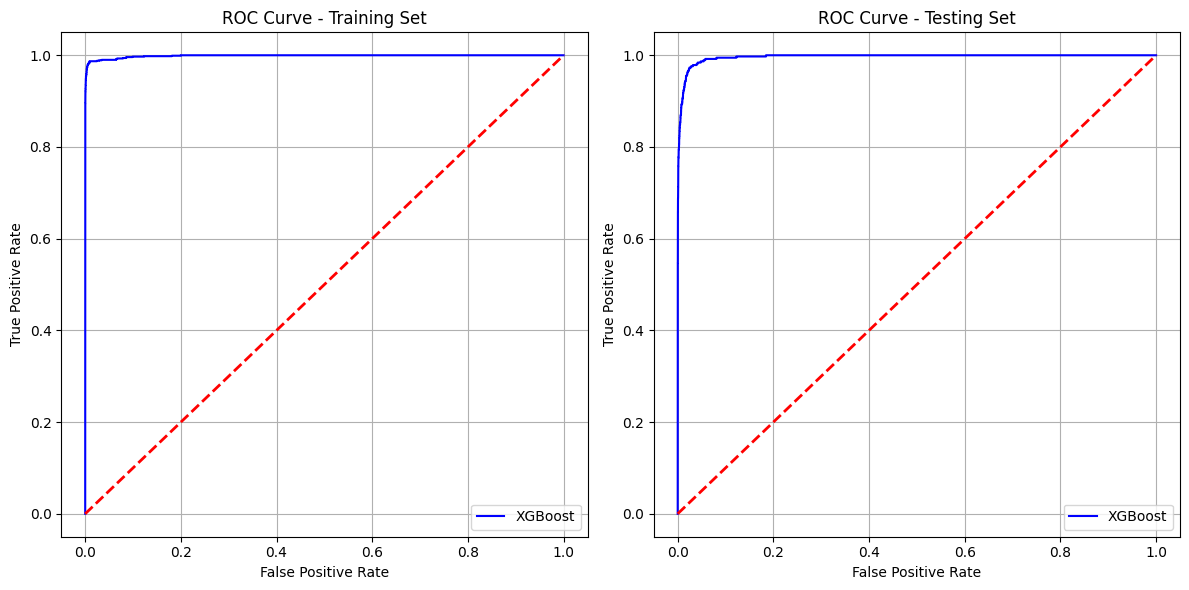

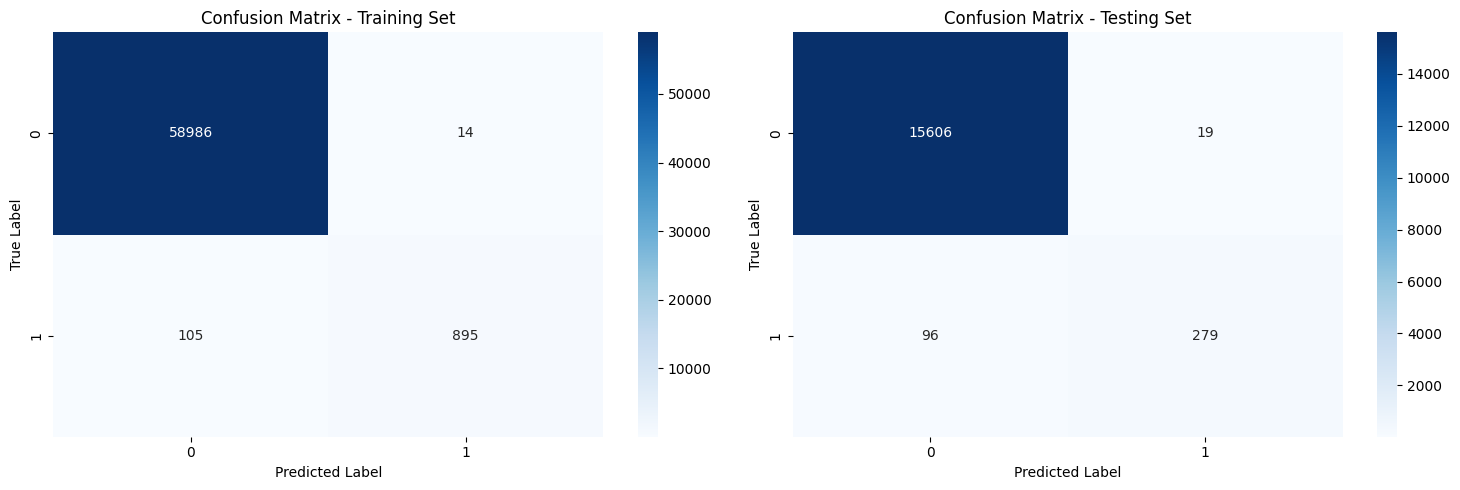

In [ ]:
dtrain = xgb.DMatrix(x_train_imputed, label=y_train_binary)
dtest = xgb.DMatrix(x_test_imputed, label=y_test_binary)

param = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

alpha_val = [0, 0.1, 0.5, 1.0, 2.0, 5.0]
cv_res = []

for alpha in alpha_val:
    param['alpha'] = alpha
    cv_results = xgb.cv(
        param,
        dtrain,
        num_boost_round=100,
        nfold=5,
        stratified=True,
        metrics='auc',
        early_stopping_rounds=10,
        seed=42,
        verbose_eval=False
    )

    best_auc = cv_results['test-auc-mean'].max()
    best_rounds = cv_results['test-auc-mean'].idxmax() + 1

    cv_res.append({
        'alpha': alpha,
        'best_auc': best_auc,
        'best_rounds': best_rounds
    })

cv_df = pd.DataFrame(cv_res)
best_alpha = cv_df.loc[cv_df['best_auc'].idxmax(), 'alpha']
best_rounds = int(cv_df.loc[cv_df['best_auc'].idxmax(), 'best_rounds'])
print(f"Best Alpha: {best_alpha}, Best Rounds: {best_rounds}")

param['alpha'] = best_alpha

xgb_model = xgb.train(
    param,
    dtrain,
    num_boost_round=best_rounds,
    verbose_eval=False
)

y_train_xgb_proba = xgb_model.predict(dtrain)
y_test_xgb_proba = xgb_model.predict(dtest)
y_train_xgb_pred = (y_train_xgb_proba >= 0.5).astype(int)
y_test_xgb_pred = (y_test_xgb_proba >= 0.5).astype(int)

cm_train_xgb = confusion_matrix(y_train_binary, y_train_xgb_pred)
cm_test_xgb = confusion_matrix(y_test_binary, y_test_xgb_pred)

tn_train_xgb, fp_train_xgb, fn_train_xgb, tp_train_xgb = cm_train_xgb.ravel()
tn_test_xgb, fp_test_xgb, fn_test_xgb, tp_test_xgb = cm_test_xgb.ravel()

accuracy_train_xgb = accuracy_score(y_train_binary, y_train_xgb_pred)
misclass_train_xgb = 1 - accuracy_train_xgb
precision_train_xgb = tp_train_xgb / (tp_train_xgb + fp_train_xgb) if (tp_train_xgb + fp_train_xgb) > 0 else 0
recall_train_xgb = tp_train_xgb / (tp_train_xgb + fn_train_xgb) if (tp_train_xgb + fn_train_xgb) > 0 else 0
f1_train_xgb = 2 * (precision_train_xgb * recall_train_xgb) / (precision_train_xgb + recall_train_xgb) if (precision_train_xgb + recall_train_xgb) > 0 else 0

accuracy_test_xgb = accuracy_score(y_test_binary, y_test_xgb_pred)
misclass_test_xgb = 1 - accuracy_test_xgb
precision_test_xgb = tp_test_xgb / (tp_test_xgb + fp_test_xgb) if (tp_test_xgb + fp_test_xgb) > 0 else 0
recall_test_xgb = tp_test_xgb / (tp_test_xgb + fn_test_xgb) if (tp_test_xgb + fn_test_xgb) > 0 else 0
f1_test_xgb = 2 * (precision_test_xgb * recall_test_xgb) / (precision_test_xgb + recall_test_xgb) if (precision_test_xgb + recall_test_xgb) > 0 else 0

auc_train_xgb = roc_auc_score(y_train_binary, y_train_xgb_proba)
auc_test_xgb = roc_auc_score(y_test_binary, y_test_xgb_proba)

print("XGBoost Training Metrics:")
print(f"Accuracy: {accuracy_train_xgb:.4f}")
print(f"Misclassification Rate: {misclass_train_xgb:.4f}")
print(f"Precision: {precision_train_xgb:.4f}")
print(f"Recall: {recall_train_xgb:.4f}")
print(f"F1 Score: {f1_train_xgb:.4f}")
print(f"AUC: {auc_train_xgb:.4f}")

print("\nXGBoost Testing Metrics:")
print(f"Accuracy: {accuracy_test_xgb:.4f}")
print(f"Misclassification Rate: {misclass_test_xgb:.4f}")
print(f"Precision: {precision_test_xgb:.4f}")
print(f"Recall: {recall_test_xgb:.4f}")
print(f"F1 Score: {f1_test_xgb:.4f}")
print(f"AUC: {auc_test_xgb:.4f}")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = {'accuracy': [], 'recall': [], 'precision': [], 'f1': [], 'auc': []}

for fold, (train_idx, val_idx) in enumerate(skf.split(x_train_imputed, y_train_binary), 1):
    x_train_fold = x_train_imputed.iloc[train_idx]
    y_train_fold = y_train_binary.iloc[train_idx]
    x_val_fold = x_train_imputed.iloc[val_idx]
    y_val_fold = y_train_binary.iloc[val_idx]

    dtrain_fold = xgb.DMatrix(x_train_fold, label=y_train_fold)
    dval_fold = xgb.DMatrix(x_val_fold, label=y_val_fold)

    model_fold = xgb.train(param, dtrain_fold, num_boost_round=best_rounds, verbose_eval=False)
    
    y_val_fold_proba = model_fold.predict(dval_fold)
    y_pred = (y_val_fold_proba >= 0.5).astype(int)

    cv_scores['accuracy'].append(accuracy_score(y_val_fold, y_pred))
    cv_scores['recall'].append(recall_score(y_val_fold, y_pred))
    cv_scores['precision'].append(precision_score(y_val_fold, y_pred))
    cv_scores['f1'].append(f1_score(y_val_fold, y_pred))
    cv_scores['auc'].append(roc_auc_score(y_val_fold, y_val_fold_proba))

print()
for metric, scores in cv_scores.items():
    print(f"{metric.capitalize()} - Mean: {np.mean(scores):.4f}, Std: {np.std(scores):.4f}")

cv_error = 1 - np.mean(cv_scores['accuracy'])
print(f"\nCross-Validation Error Rate: {cv_error:.4f}")

fpr_train_xgb, tpr_train_xgb, _ = roc_curve(y_train_binary, y_train_xgb_proba)
fpr_test_xgb, tpr_test_xgb, _ = roc_curve(y_test_binary, y_test_xgb_proba)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].plot(fpr_train_xgb, tpr_train_xgb, label='XGBoost', color='blue')
axes[0].plot([0, 1], [0, 1], 'r--', lw=2)
axes[0].set_title('ROC Curve - Training Set')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend()
axes[0].grid()

axes[1].plot(fpr_test_xgb, tpr_test_xgb, label='XGBoost', color='blue')
axes[1].plot([0, 1], [0, 1], 'r--', lw=2)
axes[1].set_title('ROC Curve - Testing Set')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.heatmap(cm_train_xgb, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - Training Set')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

sns.heatmap(cm_test_xgb, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix - Testing Set')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()



### (f) Use SMOTE to pre-process your data

Best Alpha with SMOTE: 1.0
XGBoost with SMOTE Training Metrics:
Accuracy: 0.9977
Misclassification Rate: 0.0023
Precision: 0.9963
Recall: 0.9991
F1 Score: 0.9977
AUC: 1.0000

XGBoost with SMOTE Testing Metrics:
Accuracy: 0.9905
Misclassification Rate: 0.0095
Precision: 0.7587
Recall: 0.8720
F1 Score: 0.8114
AUC: 0.9952

Accuracy - Mean: 0.9907, Std: 0.0008
Recall - Mean: 0.8490, Std: 0.0136
Precision - Mean: 0.6752, Std: 0.0241
F1 - Mean: 0.7519, Std: 0.0168
Auc - Mean: 0.9875, Std: 0.0039

Cross-Validation Error Rate with SMOTE: 0.0093
Test Error Rate with SMOTE: 0.0095


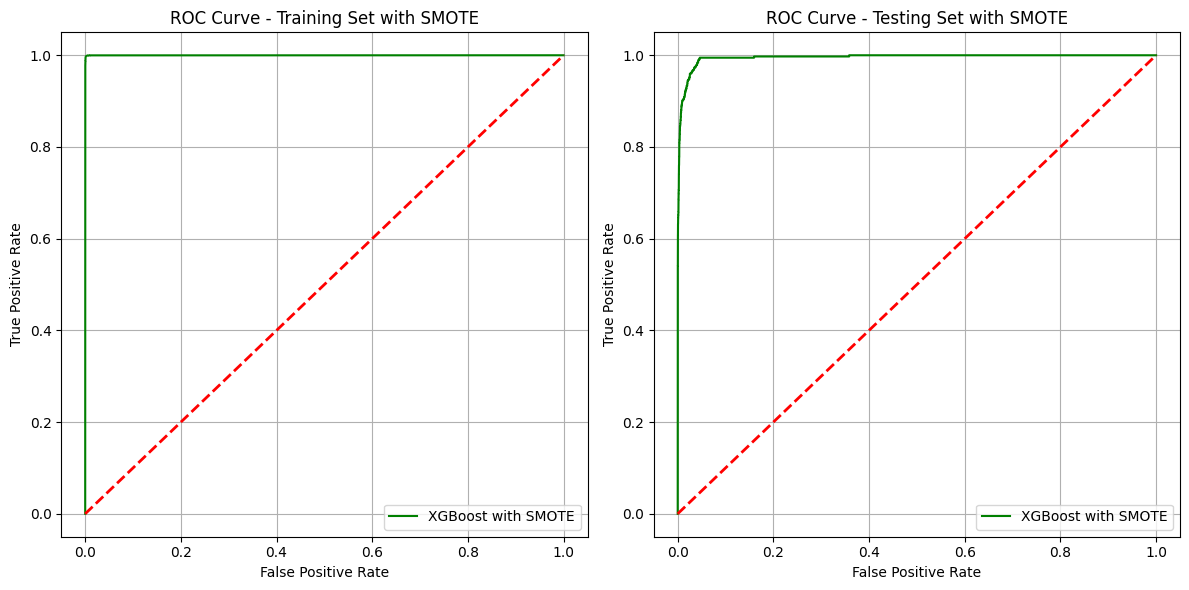

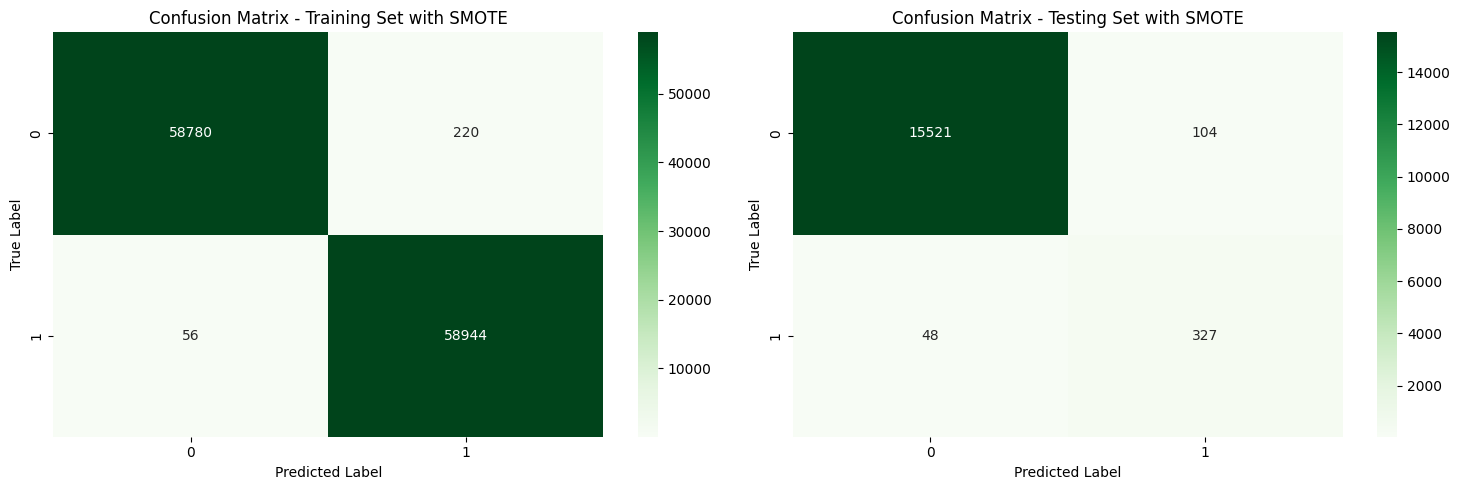

In [31]:
smote = SMOTE(random_state=42, k_neighbors=5)
x_train_smote, y_train_smote = smote.fit_resample(x_train_imputed, y_train_binary)

dtrain_smote = xgb.DMatrix(x_train_smote, label=y_train_smote)
dtest = xgb.DMatrix(x_test_imputed, label=y_test_binary)

param = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

alpha_val = [0, 0.1, 0.5, 1.0, 2.0, 5.0]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_res_smote = []

for alpha in alpha_val:
    param['alpha'] = alpha
    fold_aucs = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(x_train_imputed, y_train_binary), 1):
        x_train_fold = x_train_imputed.iloc[train_idx]
        y_train_fold = y_train_binary.iloc[train_idx]
        x_val_fold = x_train_imputed.iloc[val_idx]
        y_val_fold = y_train_binary.iloc[val_idx]

        smote_fold = SMOTE(random_state=42, k_neighbors=5)
        x_train_fold_smote, y_train_fold_smote = smote.fit_resample(x_train_fold, y_train_fold)

        dtrain_fold = xgb.DMatrix(x_train_fold_smote, label=y_train_fold_smote)
        dval_fold = xgb.DMatrix(x_val_fold, label=y_val_fold)

        model_fold = xgb.train(param, dtrain_fold, num_boost_round=100, verbose_eval=False)
        
        y_val_fold_proba = model_fold.predict(dval_fold)
        fold_auc = roc_auc_score(y_val_fold, y_val_fold_proba)
        fold_aucs.append(fold_auc)

    mean_auc = np.mean(fold_aucs)
    cv_res_smote.append({
        'alpha': alpha,
        'mean_auc': mean_auc
    })

cv_df_smote = pd.DataFrame(cv_res_smote)
best_alpha_smote = cv_df_smote.loc[cv_df_smote['mean_auc'].idxmax(), 'alpha']
print(f"Best Alpha with SMOTE: {best_alpha_smote}")

param['alpha'] = best_alpha_smote
xgb_smote_model = xgb.train(
    param,
    dtrain_smote,
    num_boost_round=best_rounds,
    verbose_eval=False
)

y_train_smote_proba = xgb_smote_model.predict(dtrain_smote)
y_test_smote_proba = xgb_smote_model.predict(dtest)
y_train_smote_pred = (y_train_smote_proba >= 0.5).astype(int)
y_test_smote_pred = (y_test_smote_proba >= 0.5).astype(int)

cm_train_smote = confusion_matrix(y_train_smote, y_train_smote_pred)
cm_test_smote = confusion_matrix(y_test_binary, y_test_smote_pred)

tn_train_smote, fp_train_smote, fn_train_smote, tp_train_smote = cm_train_smote.ravel()
tn_test_smote, fp_test_smote, fn_test_smote, tp_test_smote = cm_test_smote.ravel()

accuracy_train_smote = accuracy_score(y_train_smote, y_train_smote_pred)
misclass_train_smote = 1 - accuracy_train_smote
precision_train_smote = tp_train_smote / (tp_train_smote + fp_train_smote) if (tp_train_smote + fp_train_smote) > 0 else 0
recall_train_smote = tp_train_smote / (tp_train_smote + fn_train_smote) if (tp_train_smote + fn_train_smote) > 0 else 0
f1_train_smote = 2 * (precision_train_smote * recall_train_smote) / (precision_train_smote + recall_train_smote) if (precision_train_smote + recall_train_smote) > 0 else 0
auc_train_smote = roc_auc_score(y_train_smote, y_train_smote_proba)

accuracy_test_smote = accuracy_score(y_test_binary, y_test_smote_pred)
misclass_test_smote = 1 - accuracy_test_smote
precision_test_smote = tp_test_smote / (tp_test_smote + fp_test_smote) if (tp_test_smote + fp_test_smote) > 0 else 0
recall_test_smote = tp_test_smote / (tp_test_smote + fn_test_smote) if (tp_test_smote + fn_test_smote) > 0 else 0
f1_test_smote = 2 * (precision_test_smote * recall_test_smote) / (precision_test_smote + recall_test_smote) if (precision_test_smote + recall_test_smote) > 0 else 0
auc_test_smote = roc_auc_score(y_test_binary, y_test_smote_proba)

print("XGBoost with SMOTE Training Metrics:")
print(f"Accuracy: {accuracy_train_smote:.4f}")
print(f"Misclassification Rate: {misclass_train_smote:.4f}")
print(f"Precision: {precision_train_smote:.4f}")
print(f"Recall: {recall_train_smote:.4f}")
print(f"F1 Score: {f1_train_smote:.4f}")
print(f"AUC: {auc_train_smote:.4f}")

print("\nXGBoost with SMOTE Testing Metrics:")
print(f"Accuracy: {accuracy_test_smote:.4f}")
print(f"Misclassification Rate: {misclass_test_smote:.4f}")
print(f"Precision: {precision_test_smote:.4f}")
print(f"Recall: {recall_test_smote:.4f}")
print(f"F1 Score: {f1_test_smote:.4f}")
print(f"AUC: {auc_test_smote:.4f}")

cv_scores_smote = {'accuracy': [], 'recall': [], 'precision': [], 'f1': [], 'auc': []}

for fold, (train_idx, val_idx) in enumerate(skf.split(x_train_imputed, y_train_binary), 1):
    x_train_fold = x_train_imputed.iloc[train_idx]
    y_train_fold = y_train_binary.iloc[train_idx]
    x_val_fold = x_train_imputed.iloc[val_idx]
    y_val_fold = y_train_binary.iloc[val_idx]

    smote_fold = SMOTE(random_state=42, k_neighbors=5)
    x_train_fold_smote, y_train_fold_smote = smote.fit_resample(x_train_fold, y_train_fold)

    dtrain_fold = xgb.DMatrix(x_train_fold_smote, label=y_train_fold_smote)
    dval_fold = xgb.DMatrix(x_val_fold, label=y_val_fold)

    model_fold = xgb.train(param, dtrain_fold, num_boost_round=best_rounds, verbose_eval=False)
    
    y_val_fold_proba = model_fold.predict(dval_fold)
    y_pred = (y_val_fold_proba >= 0.5).astype(int)

    cv_scores_smote['accuracy'].append(accuracy_score(y_val_fold, y_pred))
    cv_scores_smote['recall'].append(recall_score(y_val_fold, y_pred))
    cv_scores_smote['precision'].append(precision_score(y_val_fold, y_pred))
    cv_scores_smote['f1'].append(f1_score(y_val_fold, y_pred))
    cv_scores_smote['auc'].append(roc_auc_score(y_val_fold, y_val_fold_proba))

print()
for metric, scores in cv_scores_smote.items():
    print(f"{metric.capitalize()} - Mean: {np.mean(scores):.4f}, Std: {np.std(scores):.4f}")

cv_error_smote = 1 - np.mean(cv_scores_smote['accuracy'])
misclass_test_smote = 1 - accuracy_test_smote
print(f"\nCross-Validation Error Rate with SMOTE: {cv_error_smote:.4f}")
print(f"Test Error Rate with SMOTE: {misclass_test_smote:.4f}")

fpr_train_smote, tpr_train_smote, _ = roc_curve(y_train_smote, y_train_smote_proba)
fpr_test_smote, tpr_test_smote, _ = roc_curve(y_test_binary, y_test_smote_proba)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].plot(fpr_train_smote, tpr_train_smote, label='XGBoost with SMOTE', color='green')
axes[0].plot([0, 1], [0, 1], 'r--', lw=2)
axes[0].set_title('ROC Curve - Training Set with SMOTE')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend()
axes[0].grid()

axes[1].plot(fpr_test_smote, tpr_test_smote, label='XGBoost with SMOTE', color='green')
axes[1].plot([0, 1], [0, 1], 'r--', lw=2)
axes[1].set_title('ROC Curve - Testing Set with SMOTE')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.heatmap(cm_train_smote, annot=True, fmt='d', cmap='Greens', ax=axes[0])
axes[0].set_title('Confusion Matrix - Training Set with SMOTE')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

sns.heatmap(cm_test_smote, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Confusion Matrix - Testing Set with SMOTE')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
plt.tight_layout()
plt.show()

## 2. ISLR 6.6.3

### (a)
Steadily decrease - as s increases, the model is able to fit the training data, the training RSS cannot increase.

### (b)
Decrease initially, and then eventually start increasing in a U shape - Test RSS will decrease at first, but will increase after due to variance and overfitting.

### (c)
Steadily increase - as the estimator becore more flexible, the variance will increase.

### (d)
Steadily decrease - as the model become more flexible, the bias will decrease.

### (e)
Remain constant - irreducible error is not affected by the flexibility of the model.


## 3. ISLR 6.6.5

### (a)
$$\hat{y}_i = \beta_1x_i+\beta_2x_i=(\beta_1+\beta_2)x_i$$
$$RSS(\beta)=\sum_{i=1}^{2}(y_i-(\beta_1+\beta_2)x_i)^2=\sum_{i=1}^2(y_i-\theta x_i)^2$$
$$min_{\beta_1,\beta_2}\sum_{i=1}^{2}(y_i-(\beta_1+\beta_2)x_i)^2 + \lambda(\beta_1^2+\beta_2^2)$$
$\theta = \beta_1+\beta_2$
$$min_{\beta_1,\beta_2}F(\beta)=\sum_{i=1}^{2}(y_i-\theta x_i)^2+\lambda(\beta_1^2+\beta_2^2)$$
### (b)
$\beta_1^2+\beta_2^2$ is minimized when $\beta_1 = \beta_2 = \theta/2$; for any real a, b, $a^2+b^2 \geq (a+b)^2/2$.

$\hat{\beta}_2 = \hat{\beta}_2 = \frac{\hat{\theta}}{2}$, $\hat{\theta}$ is minimizer of $min_{\theta}\sum_{i=1}^{2}(y_i-\theta x_i)^2 + \frac{\lambda}{2}\theta^2$.
### (c)
$$min_{\beta_1,\beta_2}\sum_{i=1}^2(y_i-(\beta_1+\beta_2)x_i)^2 + \lambda(|\beta_1|+|\beta_2|)$$
### (d)
Lasso reduces to choosing $\theta$ with $\beta_1+\beta_2=\theta$ where $P(\beta)=|\beta_1|+|\beta_2|$

If $\hat{\beta}$ is positive, $\beta_1+\beta_2 =\hat{\theta}$ yields $P(\beta)=\hat{\theta}$, minimized when $\beta_1=0$ or $\beta_2=0$.

If $\hat{\beta}$ is negative, $\beta_1+\beta_2=\hat{\theta}$ yields $P(\beta)=-\hat{\theta}$, minimized when $\beta_1=0$ or $\beta_2=0$.

Lasso are not unique in this case.

{$({\beta}_1,{\beta}_2): {\beta}_1 + {\beta}_2 = \hat{\theta}, {\beta}_1 \geq 0, {\beta}_2 \geq 0$} where $\hat{\beta}>0$

## 4. ISLR 8.4.5

Majority vote: Red if estimator > 0.5. six estimates are greater than 0.5, 4 estimates are less than 0.5, so the final classification is Red.

Average probability: (0.1+0.15+0.2+0.2+0.55+0.6+0.6+0.65+0.7+0.75)/10 = 0.45 < 0.5, so the final classification is Green.

## 5. ISLR 9.7.3

### (a)

<function matplotlib.pyplot.show(close=None, block=None)>

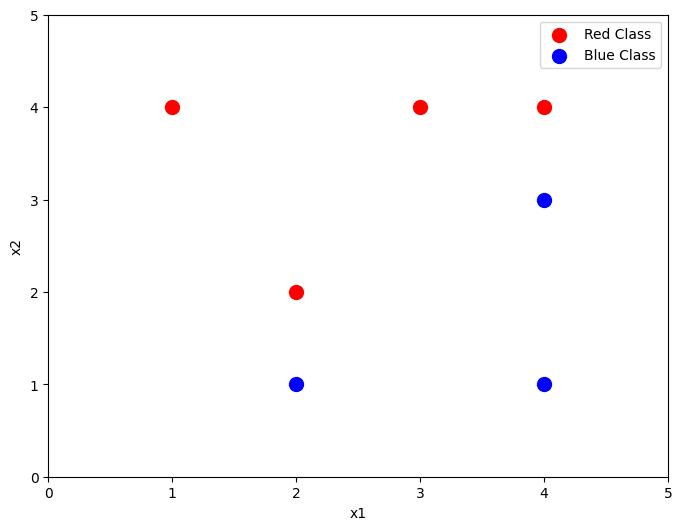

In [32]:
# (a)

red = [(3, 4), (2, 2), (4, 4), (1, 4)]
blue =[(2, 1), (4, 3), (4, 1)]

red_x, red_y = zip(*red)
blue_x, blue_y = zip(*blue)

plt.figure(figsize=(8, 6))
plt.scatter(red_x, red_y, color='red', label='Red Class', s=100)
plt.scatter(blue_x, blue_y, color='blue', label='Blue Class', s=100)

plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.xlim(0, 5)
plt.ylim(0, 5)

plt.show

### (b)

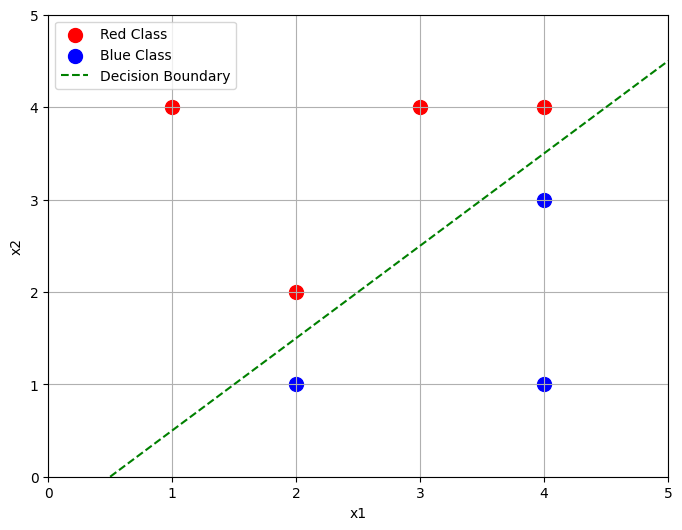

In [40]:
x1_val = np.linspace(0, 5, 100)
x2_val = x1_val - 0.5

plt.figure(figsize=(8, 6))
plt.scatter(red_x, red_y, color='red', label='Red Class', s=100)
plt.scatter(blue_x, blue_y, color='blue', label='Blue Class', s=100)
plt.plot(x1_val, x2_val, color='green', linestyle='--', label='Decision Boundary')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.grid()
plt.show()

### (c)
let the classifier be $f(x)=0.5-x_1+x_2$.
Classify to Red if f(x) > 0, blue otherwise.

### (d)

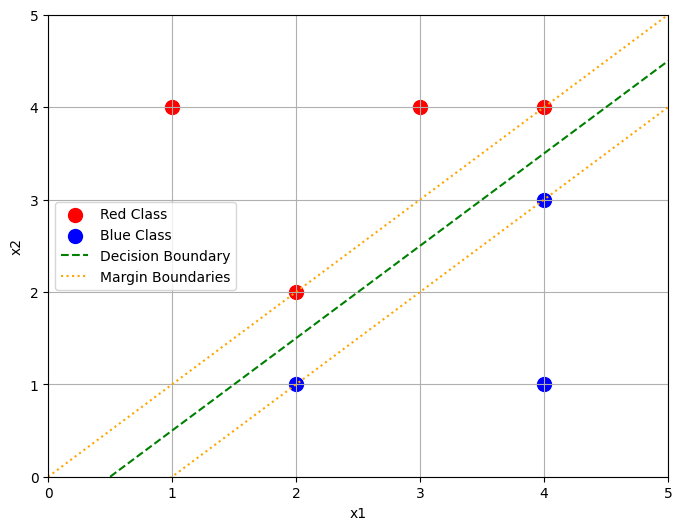

In [50]:
margin = 0.5 / np.sqrt(2)

x2_upper = x1_val - 0.5 + margin * np.sqrt(2)
x2_lower = x1_val - 0.5 - margin * np.sqrt(2)

plt.figure(figsize=(8, 6))
plt.scatter(red_x, red_y, color='red', label='Red Class', s=100)
plt.scatter(blue_x, blue_y, color='blue', label='Blue Class', s=100)
plt.plot(x1_val, x2_val, color='green', linestyle='--', label='Decision Boundary')
plt.plot(x1_val, x2_upper, color='orange', linestyle=':', label='Margin Boundaries')
plt.plot(x1_val, x2_lower, color='orange', linestyle=':')

plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.grid()
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.show()


### (e)
Support vectors: Red: (2, 2), (4, 4); Blue:(2, 1), (4, 3)

### (f)
If the movement is small, it will not affect the maximal margin hyperplane. But if the movement is large enough to change the support vectors, the hyperplane will be affected.

### (g)

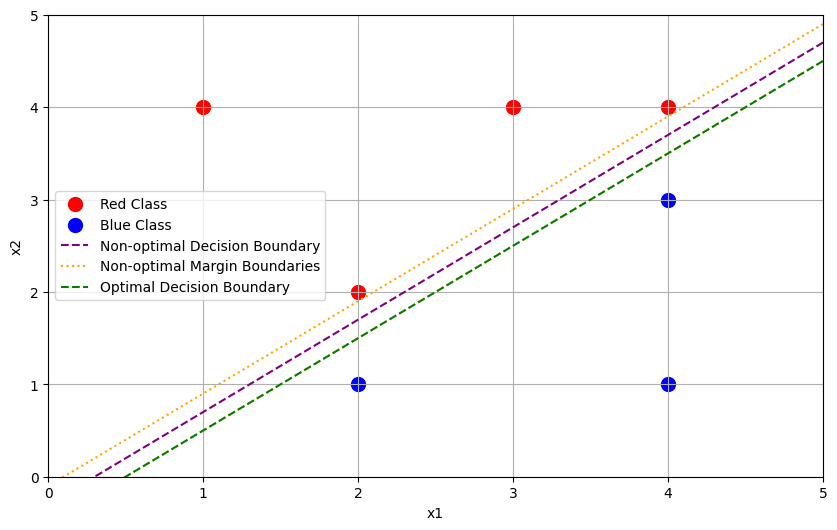

In [52]:
nonopt = 0.2
opt = 0.5
margin_nonopt = abs(nonopt) / np.sqrt(2)

x_vals = np.linspace(0, 5, 200)

x1_val = np.linspace(0, 5, 200)
x2_nonopt = x1_val - 0.5 + nonopt
x2_opt = x1_val - opt

x2_nonopt_upper = x2_nonopt + margin_nonopt * np.sqrt(2)
x2_nonopt_lower = x2_nonopt - margin_nonopt * np.sqrt(2)

plt.figure(figsize=(10, 6))
plt.scatter([p[0] for p in red], [p[1] for p in red], color='red', label='Red Class', s=100)
plt.scatter([p[0] for p in blue], [p[1] for p in blue], color='blue', label='Blue Class', s=100)
plt.plot(x1_val, x2_nonopt, color='purple', linestyle='--', label='Non-optimal Decision Boundary')
plt.plot(x1_val, x2_nonopt_upper, color='orange', linestyle=':', label='Non-optimal Margin Boundaries')
plt.plot(x1_val, x2_nonopt_lower, color='orange', linestyle=':')
plt.plot(x1_val, x2_opt, color='green', linestyle='--', label='Optimal Decision Boundary')

plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.grid()
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.show()

Non-optiomal equation: $x_2-x_1+0.2=0$

### (h)

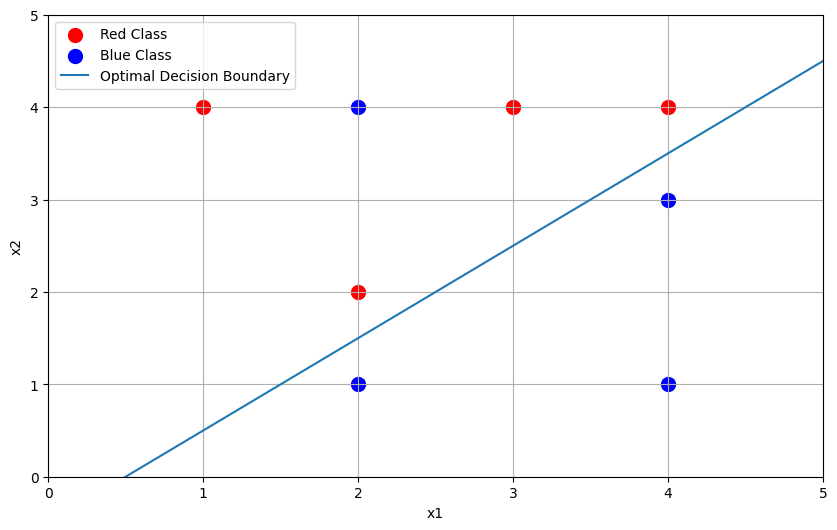

In [57]:
red = [(3, 4), (2, 2), (4, 4), (1, 4)]
blue =[(2, 1), (4, 3), (4, 1), (2, 4)]

non_sep = 0.8
x1_val = np.linspace(0, 5, 200)
x2_sep = x1_val - non_sep

opt = 0.5
x2_opt = x1_val - opt

plt.figure(figsize=(10, 6))
plt.scatter([p[0] for p in red], [p[1] for p in red], color='red', label='Red Class', s=100)
plt.scatter([p[0] for p in blue], [p[1] for p in blue], color='blue', label='Blue Class', s=100)
plt.plot(x1_val, x2_opt, '-', label='Optimal Decision Boundary')

plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.grid()
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.show()

The two classes are not longer separable by a hyperplane after adding a new point.